# Data cleaning

In [1]:
#import all packages needed 
import pandas as pd
import numpy as np 
import re
from datetime import datetime 
import ast
from collections import Counter
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import geopandas as gpd
from scipy.stats import ttest_ind
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pysal.lib.weights import KNN
from pysal.explore import esda
!pip install urbanaccess pandana


#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Data/2. airbnb_data/Paris/Paris all detailed listings/Paris_Q1_detailed_listings.xlsx'
#read data, and quickly check if it is correctly read in
dataframe1= pd.read_excel(file_path)

C:\Users\anton\anaconda3\Lib\site-packages\pysal\lib\cg\alpha_shapes.py:33: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\anton\anaconda3\Lib\site-packages\pysal\lib\cg\alpha_shapes.py:154: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\anton\anaconda3\Lib\site-packages\pysal\lib\cg\alpha_shapes.py:187: NumbaDeprecationWarning: The 'no

In [ ]:
#quickly looking with which data types we are dealing
print(dataframe1.dtypes)

In [ ]:
dataframe1.info()

# Data cleaning listings

In [2]:
#decided which columns will not be relevant for the first initial analysis
columns_to_drop =["name","description","host_location","host_thumbnail_url","host_name","bathrooms",
                  "listing_url","scrape_id","last_scraped", "host_picture_url","host_url", "host_has_profile_pic", 
                  "host_verifications","source","calendar_last_scraped","license","picture_url","host_about",
                             "neighbourhood","neighbourhood_group_cleansed","minimum_minimum_nights",
                             "maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights",
                             "minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated",
                             "neighborhood_overview","host_neighbourhood", "host_acceptance_rate"]
dataframe1 = dataframe1.drop(columns_to_drop, axis=1)

#solving trailing white space problem
string_columns = dataframe1.select_dtypes(include='object').columns.tolist()
for i in string_columns:
    dataframe1[i] = dataframe1[i].str.strip()

#missing values have always been checked during this cleaning with the function: print(dataframe1.isnull().mean()) 

#host_repsonse_time, filling in the empty ones with "unknown"
dataframe1.host_response_time.fillna("unknown", inplace=True)
dataframe1.host_response_time.value_counts(normalize=True)

#adapting the host_response_rate column to better fit
# Removing the % sign from the host_response_rate string and converting to an integer
dataframe1.host_response_rate = dataframe1.host_response_rate.str[:-1].astype('float64')
# Bin into four categories
dataframe1.host_response_rate = pd.cut(dataframe1.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)
# Converting to string
dataframe1.host_response_rate = dataframe1.host_response_rate.astype('str')
# Replace nulls with 'unknown'
dataframe1.host_response_rate.replace('nan', 'unknown', inplace=True)

#these rows do not have that big of a missing value amount so we just delete the missing value rows here
col = ["host_since","host_identity_verified","host_listings_count","host_total_listings_count","host_is_superhost"]
for column in col:
    dataframe1.dropna(subset=[column], inplace=True)

# Category counts
dataframe1.host_response_rate.value_counts()
#fill out all NaN within string columns with ''
for column in string_columns:
    dataframe1[column] = dataframe1[column].fillna("")   

#fixing the "bathroom_text" column to only numbers and renaming it
def extract_numeric(value):
    numeric_part = re.search(r'\d+\.\d+|\d+', str(value))
    return float(numeric_part.group()) if numeric_part else None
dataframe1['bathrooms_text'] = dataframe1['bathrooms_text'].apply(extract_numeric)
dataframe1.rename(columns={'bathrooms_text': 'bathrooms'}, inplace=True)

#dropping those that still have no bathroom amount 
dataframe1.dropna(subset=["bathrooms"], inplace=True)
    
#delete those that have no information about both beds and bedrooms
dataframe1.dropna(subset=['beds', 'bedrooms'], how='all', inplace=True)

#dropping those with +4 bedrooms (outliers) and no information about bedroom and between 1-4 beds is a studio so 0 bedrooms
dataframe1.loc[(dataframe1['bedrooms'].isnull()) & (dataframe1['beds'].between(1, 4)), 'bedrooms'] = 0
dataframe1.drop(dataframe1[(dataframe1['bedrooms'].isnull()) & (dataframe1['beds'] > 4)].index, inplace=True)

#fill in all the other empty values with the amount of bedrooms 
dataframe1['beds'].fillna(dataframe1['bedrooms'], inplace=True)

#dropping those that still have no bedroom amount 
dataframe1.dropna(subset=["bedrooms"], inplace=True)

dataframe1['first_review'] = pd.to_datetime(dataframe1['first_review']) 
# Calculating the number of days
dataframe1['days_since_first_review'] = (datetime(2024, 1, 20) - dataframe1['first_review']).dt.days
# Printing descriptives
#dataframe1.hist(['days_since_first_review'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365
#DOING Binning time since last review
dataframe1['days_since_first_first_review'] = pd.qcut(dataframe1['days_since_first_review'], q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])

dataframe1['last_review'] = pd.to_datetime(dataframe1['last_review']) 
# Calculating the number of days
dataframe1['days_since_last_review'] = (datetime(2024, 1, 20) - dataframe1['last_review']).dt.days
# Printing descriptives
#dataframe1.hist(['days_since_last_review'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365
#DOING Binning time since last review
dataframe1['days_since_last_last_review'] = pd.qcut(dataframe1['days_since_last_review'], q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])

#adding a column with the information if a listing has a review or not
dataframe1['zero_reviews'] = dataframe1['number_of_reviews'] == 0

dataframe1['host_since'] = pd.to_datetime(dataframe1['host_since']) 
# Calculating the number of days
dataframe1['days_since_host'] = (datetime(2024, 1, 20) - dataframe1['host_since']).dt.days
# Printing descriptives
#dataframe1.hist(['days_since_host'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365
#DOING Binning time since last review
dataframe1['days_since_host_host'] = pd.qcut(dataframe1['days_since_host'], q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])

#Simplifying the property_types in to 4 categories
dataframe1.property_type.replace({
    'Barn': 'House',
    'Boat': 'Other',
    'Bus': 'Other',
    'Camper/RV': 'Other',
    'Casa particular': 'House',
    'Cave': 'Other',
    'Dome': 'Other',
    'Earthen home': 'House',
    'Entire bed and breakfast': 'Hotel',    
    'Entire bungalow': 'House',
    'Entire condo': 'Apartmen',
    'Entire guesthouse': 'House',
    'Entire home': 'House',
    'Entire guest suite': 'Apartment',
    'Entire rental unit': 'Apartment',
    'Entire loft': 'Apartment',
    'Entire home/apt': 'House',
    'Entire place': 'House',
    'Entire serviced apartment': 'Apartment',
    'Entire townhouse': 'House',
    'Entire villa': 'House',
    'Entire vacation home': 'House',
    'Floor': 'Other',
    'Houseboat': 'Other',
    'Private room': 'Apartment',
    'Island': 'Other',
    'Private room in bed and breakfast': 'Hotel',    
    'Private room in boat': 'Other',
    'Private room in casa particular': 'House',
    'Private room in condo': 'Apartment',
    'Private room in guest suite': 'Apartment',
    'Private room in earthen home': 'House',
    'Private room in home': 'House',
    'Private room in guesthouse': 'House',
    'Private room in loft': 'Apartment',
    'Private room in hostel': 'Hotel',
    'Private room in rental unit': 'Apartment',
    'Private room in townhouse': 'House',
    'Private room in tiny home': 'House',
    'Private room in serviced apartment': 'Apartment',
    'Room in bed and breakfast': 'Hotel',
    'Private room in villa': 'House',
    'Room in serviced apartment': 'Apartment',
    'Room in boutique hotel': 'Hotel',
    'Room in hotel': 'Hotel',
    'Room in hostel': 'Hotel',
    'Shared room in bed and breakfast': 'Hotel',
    'Shared room in boutique hotel': 'Hotel',
    'Shared room in cabin': 'Other',
    'Shared room in boat': 'Other',
    'Shared room in condo': 'Apartment',
    'Shared room in farm stay': 'Other',
    'Shared room in guesthouse': 'House',
    'Shared room in casa particular': 'House',
    'Shared room in ice dome': 'Other',
    'Shared room in home': 'House',
    'Shared room in hostel': 'Hotel',
    'Shared room in hotel': 'Hotel',
    'Shared room in rental unit': 'Apartment',
    'Tiny home': 'House',
    'Shared room in loft': 'Apartment',
    'Shared room in townhouse': 'House',
    'Shared room in tiny home': 'House',
    }, inplace=True)

# Replacing other categories with 'other'
dataframe1.loc[~dataframe1.property_type.isin(['House', 'Apartment','Hotel']), 'property_type'] = 'Other'
#dataframe1['property_type'].value_counts()

#changing the name from neighbourhoud_cleansed to neighbourhood
dataframe1.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

#convert the necessary columns to a boolean type, which is easier to use
columns_to_convert = ['host_is_superhost', 'instant_bookable', 'host_identity_verified',"has_availability"] 
for column in columns_to_convert:
    dataframe1[column] = dataframe1[column].replace({'f': False, 't': True}).astype(bool)

In [3]:
# Convert the string representation of lists to actual lists
dataframe1["amenities"] = dataframe1["amenities"].apply(ast.literal_eval)

In [4]:
#making a unique list out of all the different kind of amenities that there are
unique_items_set = set.union(*dataframe1["amenities"].apply(set))
print(unique_items_set)
print(len(unique_items_set)) #first we come to  5829 different amenities
#the one that is shown here is taken after the adjustments you can see below

{'Not furnished shampoo', '40" HDTV with DVD player', 'HDTV with Netflix, Amazon Prime Video, premium cable, standard cable', '65" HDTV with Apple TV, premium cable, Netflix', '40" HDTV with Amazon Prime Video, Netflix, standard cable, premium cable', 'Moulinex combiné convection et microonde oven', 'Unscented body soap', 'Carrefour  stainless steel oven', '48" HDTV with Disney+, Amazon Prime Video, Netflix', 'Head & Shoulders shampoo', 'Mixa shampoo', 'Beko  stainless steel oven', 'Indesit  stainless steel single oven', 'Divers refrigerator', 'Mini four Brandt stainless steel oven', 'Scholtes  induction stove', '42" HDTV with Chromecast, Disney+, Netflix, Amazon Prime Video', 'Neff stainless steel gas stove', 'Intermarché body soap', 'JBL Bluetooth speaker sound system', 'Fast wifi – 593 Mbps', 'Fast wifi – 118 Mbps', 'Siemens stove', 'Durance body soap', '65" HDTV with Netflix, standard cable', 'Panasonic sound system with Bluetooth and aux', 'TV with Fire TV, Netflix', 'Marantz and 

In [5]:
#with the code down below we will simplify the amenities to reduce the amount of amenities

oven_items_set = {item for item in unique_items_set if 'oven' in item.lower()}
def replace_oven_items(item_list):
    return ['oven' if item in oven_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_oven_items)

soap_items_set = {item for item in unique_items_set if 'soap' in item.lower()}
def replace_soap_items(item_list):
    return ['soap' if item in soap_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_soap_items)

shampoo_items_set = {item for item in unique_items_set if 'shampoo' in item.lower()}
def replace_shampoo_items(item_list):
    return ['shampoo' if item in shampoo_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_shampoo_items)

wifi_items_set = {item for item in unique_items_set if 'wifi' in item.lower()}
def replace_wifi_items(item_list):
    return ['wifi' if item in wifi_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_wifi_items)

special_items_set = {item for item in unique_items_set if any(keyword in item for keyword in ['Netflix', 'Disney+', 'Amazon Prime'])}
def replace_and_add_broadcast(item_list):
    # Replace items from special_items_set with 'Broadcast'
    item_list = ['broadcast' if item in special_items_set else item for item in item_list]
    # Add 'TV' to the list if modified
    modified = any(item == 'broadcast' for item in item_list)
    if modified:
        item_list.append('TV')
    return item_list
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_and_add_broadcast)

tv_items_set = {item for item in unique_items_set if 'tv' in item.lower()}
def replace_tv_items(item_list):
    return ['tv' if item in tv_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_tv_items)

ref_items_set = {item for item in unique_items_set if 'refrigerator' in item.lower()}
def replace_ref_items(item_list):
    return ['refrigerator' if item in ref_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_ref_items)

coffee_items_set = {item for item in unique_items_set if 'coffee' in item.lower()}
def replace_coffee_items(item_list):
    return ['coffee' if item in coffee_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_coffee_items)

sound_items_set = {item for item in unique_items_set if any(keyword in item for keyword in ['sound system', 'Bluetooth'])}
def replace_sound_items(item_list):
    item_list = ['sound system' if item in sound_items_set else item for item in item_list]
    return item_list
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_sound_items)

stove_items_set = {item for item in unique_items_set if 'stove' in item.lower()}
def replace_stove_items(item_list):
    return ['stove' if item in stove_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_stove_items)

cond_items_set = {item for item in unique_items_set if 'conditioner' in item.lower()}
def replace_cond_items(item_list):
    return ['conditioner' if item in cond_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_cond_items)

park_items_set = {item for item in unique_items_set if 'parking' in item.lower()}
def replace_park_items(item_list):
    return ['parking' if item in park_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_park_items)

clothing_items_set = {item for item in unique_items_set if 'clothing storage' in item.lower()}
def replace_clothing_items(item_list):
    return ['clothing storage' if item in clothing_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_clothing_items)

exercise_items_set = {item for item in unique_items_set if 'exercise equipment' in item.lower()}
def replace_exercise_items(item_list):
    return ['exercise equipment' if item in exercise_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_exercise_items)

children_items_set = {item for item in unique_items_set if 'children' in item.lower()}
def replace_children_items(item_list):
    return ['toys children' if item in children_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_children_items)

bbq_items_set = {item for item in unique_items_set if 'bbq' in item.lower()}
def replace_bbq_items(item_list):
    return ['bbq' if item in bbq_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_bbq_items)

pool_items_set = {item for item in unique_items_set if 'pool' in item.lower()}
def replace_pool_items(item_list):
    return ['pool' if item in pool_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_pool_items)

hot_items_set = {item for item in unique_items_set if 'hot tub' in item.lower()}
def replace_hot_items(item_list):
    return ['hot tub' if item in hot_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_hot_items)

backyard_items_set = {item for item in unique_items_set if 'backyard' in item.lower()}
def replace_backyard_items(item_list):
    return ['backyard' if item in backyard_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_backyard_items)

gym_items_set = {item for item in unique_items_set if 'gym' in item.lower()}
def replace_gym_items(item_list):
    return ['gym' if item in gym_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_gym_items)

view_items_set = {item for item in unique_items_set if 'view' in item.lower()}
def replace_view_items(item_list):
    return ['view' if item in view_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_view_items)

crib_items_set = {item for item in unique_items_set if 'crib' in item.lower()}
def replace_crib_items(item_list):
    return ['crib' if item in crib_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_crib_items)

gc_items_set = {item for item in unique_items_set if 'game console' in item.lower()}
def replace_gc_items(item_list):
    return ['game console' if item in gc_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_gc_items)

In [6]:
#last step to clean the amenities is removing the ones that do not appear 1000 times or more in the column
flat_list = [word for sublist in dataframe1["amenities"] for word in sublist]
word_counts = Counter(flat_list)
filtered_word_set = {word for word, count in word_counts.items() if count < 1000}
common_elements = list(filtered_word_set & unique_items_set)

def remove_common_elements(item_list):
    return [item for item in item_list if item not in common_elements]
dataframe1['amenities'] = dataframe1['amenities'].apply(remove_common_elements)

unique_items_set = set.union(*dataframe1["amenities"].apply(set))
#only 94 unique items left, which is an acceptable amount and now we can make columns out of these ones

In [8]:
#making new columns for the amenities indivually with a 0 or 1 inside of them 
for item in unique_items_set:
    dataframe1[item] = dataframe1["amenities"].apply(lambda x: int(item in x))

In [9]:
#now we will be able to remove the 'amenities' column
dataframe1 = dataframe1.drop('amenities', axis=1)

In [11]:
# Calculate the total number of amenities for each listing and make this a new column
dataframe1['total_amenities'] = dataframe1.iloc[:, 51:-1].sum(axis=1)

In [12]:
# Convert columns with exclusively 0s and 1s to boolean
for col in dataframe1.columns:
    unique_values = dataframe1[col].unique()
    if set(unique_values).issubset({0, 1}):
        dataframe1[col] = dataframe1[col].astype(bool)

In [13]:
#with the following code we are going to eliminate the outliers regarding the columns: bedrooms, beds and bathrooms

x = "bedrooms"

# Calculate the percentage of each bedroom count relative to all listings
bedrooms_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Identify bedroom counts with percentage <= 0.01%
bedrooms_to_drop = bedrooms_percentage[bedrooms_percentage <= 0.01].index

# Drop rows with bedrooms counts <= 0.01%
dataframe1 = dataframe1[~dataframe1[x].isin(bedrooms_to_drop)]

# Display the percentage of each bedroom count after filtering
filtered_bedroom_percentage = dataframe1[x].value_counts(normalize=True) * 100
for bedrooms, percentage in filtered_bedroom_percentage.items():
    print(f'The percentage of listings with {bedrooms} bedroom(s) is: {percentage:.2f}%')
    
y = "bathrooms"

# Calculate the percentage of each bathroom count relative to all listings
bathrooms_percentage = dataframe1[y].value_counts(normalize=True) * 100

# Identify bathroom counts with percentage <= 0.01%
bathrooms_to_drop = bathrooms_percentage[bathrooms_percentage <= 0.01].index

# Drop rows with bathrooms counts <= 0.01%
dataframe1 = dataframe1[~dataframe1[y].isin(bathrooms_to_drop)]

# Display the percentage of each bathroom count after filtering
filtered_bathroom_percentage = dataframe1[y].value_counts(normalize=True) * 100
for bathrooms, percentage in filtered_bathroom_percentage.items():
    print(f'The percentage of listings with {bathrooms} bathroom(s) is: {percentage:.2f}%')
    
z = "beds"

# Calculate the percentage of each bed count relative to all listings
beds_percentage = dataframe1[z].value_counts(normalize=True) * 100

# Identify bed counts with percentage <= 0.01%
beds_to_drop = beds_percentage[beds_percentage <= 0.01].index

# Drop rows with bed counts <= 0.01%
dataframe1 = dataframe1[~dataframe1[z].isin(beds_to_drop)]

# Display the percentage of each bed count after filtering
filtered_beds_percentage = dataframe1[z].value_counts(normalize=True) * 100
for beds, percentage in filtered_beds_percentage.items():
    print(f'The percentage of listings with {beds} bed(s) is: {percentage:.2f}%')

The percentage of listings with 1.0 bedroom(s) is: 62.33%
The percentage of listings with 0.0 bedroom(s) is: 15.70%
The percentage of listings with 2.0 bedroom(s) is: 15.69%
The percentage of listings with 3.0 bedroom(s) is: 4.81%
The percentage of listings with 4.0 bedroom(s) is: 1.17%
The percentage of listings with 5.0 bedroom(s) is: 0.22%
The percentage of listings with 6.0 bedroom(s) is: 0.06%
The percentage of listings with 7.0 bedroom(s) is: 0.02%
The percentage of listings with 50.0 bedroom(s) is: 0.01%
The percentage of listings with 1.0 bathroom(s) is: 86.00%
The percentage of listings with 2.0 bathroom(s) is: 6.14%
The percentage of listings with 1.5 bathroom(s) is: 5.38%
The percentage of listings with 2.5 bathroom(s) is: 1.11%
The percentage of listings with 3.0 bathroom(s) is: 0.77%
The percentage of listings with 0.0 bathroom(s) is: 0.22%
The percentage of listings with 3.5 bathroom(s) is: 0.15%
The percentage of listings with 4.0 bathroom(s) is: 0.11%
The percentage of 

In [ ]:
dataframe1.info()

In [ ]:
#downloading the cleaned_dataset
dataframe1.to_excel('cleaned_dataset.xlsx', index=False)

# Data cleaning Seasonality

In [14]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np
%matplotlib inline

#reading in the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Data/2. airbnb_data/Paris/Q1 airbnb_data Paris/calendar/calendar.csv'
data = pd.read_csv(file_path)

In [ ]:
data.info()

In [15]:
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)
data['adjusted_price'] = data['adjusted_price'].replace('[\$,]', '', regex=True).astype(float)
data['date']=pd.to_datetime(data['date'])
data['weekday'] = pd.Series(data.date).dt.dayofweek
data.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,weekday
0,5396,2023-03-14,f,123.0,123.0,1.0,1125.0,1
1,5396,2023-03-15,f,123.0,123.0,1.0,1125.0,2
2,5396,2023-03-16,f,124.0,124.0,1.0,1125.0,3
3,5396,2023-03-17,f,124.0,124.0,1.0,1125.0,4
4,5396,2023-03-18,f,124.0,124.0,1.0,1125.0,5


In [ ]:
print(data.isnull().mean()) 

In [16]:
#removing the missing values from the dataset after seeing that there are not that many missing values
data.dropna(inplace=True)
print(data.isnull().mean())

listing_id        0.0
date              0.0
available         0.0
price             0.0
adjusted_price    0.0
minimum_nights    0.0
maximum_nights    0.0
weekday           0.0
dtype: float64


In [ ]:
# Check if 'price' and 'adjusted_price' are always the same
are_equal = (data['price'] == data['adjusted_price']).all()
if are_equal:
    print("The 'price' and 'adjusted_price' columns always have the same values.")
else:
    print("There are differences between 'price' and 'adjusted_price' values.")

# Data exploration Calendar data

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import seaborn as sb
import numpy as np
import datetime as dt
import csv
from datetime import datetime
%matplotlib inline


# Taking average/median values as well as plotting
date = []
avg_price = []
median_price = []
avg_adjusted_price = []
median_adjusted_price = []

for i in data['date'].unique():
    date.append(i)
    avg_price.append(data[data['date'] == i]['price'].mean())
    median_price.append(data[data['date'] == i]['price'].median())
    avg_adjusted_price.append(data[data['date'] == i]['adjusted_price'].mean())
    median_adjusted_price.append(data[data['date'] == i]['adjusted_price'].median())

plt.plot(range(len(avg_price)), avg_price, label="Average Price")
plt.plot(range(len(avg_price)), median_price, color='red', label="Median Price")
plt.plot(range(len(avg_adjusted_price)), avg_adjusted_price, label="Average Adjusted Price")
plt.plot(range(len(avg_adjusted_price)), median_adjusted_price, color='green', label="Median Adjusted Price")

plt.ylabel('Price($)')
plt.xlabel('Day of Q1 2023 - Q1 2024')
plt.title('Average and Median Price of Q1 2023 - Q1 2024 AirBnB Listings Paris')
plt.legend()
plt.show()

In [ ]:
#Doing the same but only for the first 70 days
plt.plot(range(len(avg_price[0:70])), avg_price[0:70], label="Average Price")
plt.plot(range(len(avg_price[0:70])), median_price[0:70], color='red', label="Median Price")
plt.plot(range(len(avg_adjusted_price[0:70])), avg_adjusted_price[0:70], label="Average Adjusted Price")
plt.plot(range(len(avg_adjusted_price[0:70])), median_adjusted_price[0:70], color='green', label="Median Adjusted Price")

plt.ylabel('Price($)')
plt.xlabel('Day of Q1 2023 - Q1 2024')
plt.title('Average and Median Price of First 70 Days of AirBnB Listings')
plt.legend()
plt.show()

In [ ]:
#looking at which day is the most expensive on average and median
daily_avg_price = []
daily_median_price = []
b = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(7):
    daily_avg_price.append(data[data['weekday'] == i]['price'].mean())
    daily_median_price.append(data[data['weekday'] == i]['price'].median())

plt.bar(range(len(daily_avg_price)), daily_avg_price, width=1 / 1.5, label="Average Price")
plt.bar(range(len(daily_median_price)), daily_median_price, width=1 / 1.5, color='red', label="Median Price")

plt.xticks(range(len(daily_avg_price)), b)
plt.ylabel('Price($)')
plt.xlabel('Day of the Week')
plt.title('Average and Median Price per Day of the Week')
plt.legend()
plt.show()

for i in range(7):
    avg_price = data[data['weekday'] == i]['price'].mean()
    median_price = data[data['weekday'] == i]['price'].median()
    
    daily_avg_price.append(avg_price)
    daily_median_price.append(median_price)

    print(f"{b[i]} - Average Price: ${avg_price:.2f}, Median Price: ${median_price:.2f}")

# Data exploration listings data

In [ ]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(dataframe1.columns[dataframe1.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    dataframe1[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#out of these we see that most of them are rated quite positive, with the biggest amount around 4-5/5 stars

In [ ]:
# Importing the Paris neighbourhood  GeoJSON file as a dataframe in geopandas
map_dataframe1 = gpd.read_file('C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Data/2. airbnb_data/Paris/Q1 airbnb_data Paris/neighbourhoods.geojson')
map_dataframe1.drop('neighbourhood_group', axis = 1, inplace = True)
map_dataframe1.head(20)

In [ ]:
#setting the characteristics for the following plot
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = 280, 280


# Creating a dataframe of listing counts and median price by neighbourhood
neighbourhood_dataframe1 = pd.DataFrame(dataframe1.groupby('neighbourhood').size())
neighbourhood_dataframe1.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_dataframe1['median_price'] = dataframe1.groupby('neighbourhood').price.median().values
neighbourhood_dataframe1['mean_price'] = dataframe1.groupby('neighbourhood').price.mean().values

# Putting the dataframes together
neighbourhood_map_dataframe1 = map_dataframe1.set_index('neighbourhood').join(neighbourhood_dataframe1)
                  
# Plotting the number of listings in each neighbourhood
fig1, ax1 = plt.subplots(1, figsize=(15, 6)) #deciding on plot size
neighbourhood_map_dataframe1.plot(column='number_of_listings', cmap='Reds', ax=ax1, rasterized=True) 
#rasterized to makes it easier for big data sets + ax1 earlier defined

ax1.axis('off') #disabling the axis components, including axis labels, ticks, and the frame surrounding the plot
ax1.set_title('Amount of listings per neighbourhood in Paris', fontsize=14)
cax1 = fig1.add_axes([0.9, 0.1, 0.03, 0.8]) # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm1 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=9000))
sm1._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar1 = fig1.colorbar(sm1, cax=cax1) 
plt.show()

# Plotting the median price of listings in each neighbourhood
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_dataframe1.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price per neighbourhood in Paris', fontsize=14)
cax2 = fig2.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm2 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(neighbourhood_map_dataframe1.median_price), vmax=max(neighbourhood_map_dataframe1.median_price))) 
sm2._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar2 = fig2.colorbar(sm2, cax=cax2)
plt.show()

# Plotting the mean price of listings in each neighbourhood
fig3, ax3 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_dataframe1.plot(column='mean_price', cmap='Reds', ax=ax3)
ax3.axis('off')
ax3.set_title('Mean price per neighbourhood in Paris', fontsize=14)
cax3 = fig3.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm3 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(neighbourhood_map_dataframe1.mean_price), vmax=max(neighbourhood_map_dataframe1.mean_price))) 
sm3._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar3 = fig3.colorbar(sm3, cax=cax3)
plt.show()

print(neighbourhood_dataframe1)

In [ ]:
# Plot number of listings and median price in one bar plot
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 25, 5
selected_columns = ['number_of_listings', 'median_price']
neighbourhood_dataframe1_selected = neighbourhood_dataframe1[selected_columns]
neighbourhood_dataframe1_sorted = neighbourhood_dataframe1_selected.sort_values('median_price', ascending=False)
neighbourhood_dataframe1_sorted.plot( kind= 'bar' , secondary_y= 'median_price' , rot= 90 )
plt.xticks(rotation='vertical')
plt.show()

# Plot number of listings and mean price in one bar plot
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 25, 5
selected_columns = ['number_of_listings', 'mean_price']
neighbourhood_dataframe1_selected = neighbourhood_dataframe1[selected_columns]
neighbourhood_dataframe1_sorted = neighbourhood_dataframe1_selected.sort_values('mean_price', ascending=False)
neighbourhood_dataframe1_sorted.plot( kind= 'bar' , secondary_y= 'mean_price' , rot= 90 )
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
def binary_count_and_price_plot(column_name,alpha=0.05):
    # Assuming dataframe1 is your DataFrame

    # Plot count distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=column_name, data=dataframe1)
    plt.title(f'Count distribution of {column_name}')

    # Plot median price distribution
    plt.subplot(1, 2, 2)
    median_prices = dataframe1.groupby(column_name)['price'].median()
    median_prices.plot(kind='bar', color=['blue', 'orange'])
    plt.title(f'Median price distribution by {column_name}')
    plt.tight_layout()
    plt.show()

    # Calculate t-test for median prices
    true_prices = dataframe1[dataframe1[column_name] == True]['price']
    false_prices = dataframe1[dataframe1[column_name] == False]['price']
    t_stat, p_value = ttest_ind(true_prices, false_prices)
   
    # Display additional information
    percent_split = dataframe1[column_name].value_counts(normalize=True) * 100
    print(f'% Wise Split of {column_name}:\n{percent_split}')
    t_statistic, p_value = ttest_ind(true_prices, false_prices, equal_var=False)  # assuming unequal variances
    print(f'\nP-value for {column_name}: {p_value}')
    
    # Check if p-value is greater than or equal to alpha
    if p_value >= alpha:
        print(f"{column_name} is not statistically significant (p-value >= {alpha})")
        return column_name
    else:
        print(f"{column_name} is statistically significant (p-value < {alpha})")
        return None  # or any other value if needed

superhost = binary_count_and_price_plot('host_is_superhost')
print(dataframe1.host_is_superhost.value_counts(normalize=True))

test2 = binary_count_and_price_plot('host_identity_verified')
print(dataframe1.host_identity_verified.value_counts(normalize=True))

test3 = binary_count_and_price_plot('instant_bookable')
print(dataframe1.instant_bookable.value_counts(normalize=True))

In [ ]:
# Get column names and their indices
column_info = list(enumerate(dataframe1.columns))
# Print column names and their indices
for index, column_name in column_info:
    print(f"Column {index}: {column_name}")
    
#now we know that the amenity columns start from index 51

In [ ]:
#doing the analysis for all the different amenities
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
result = [binary_count_and_price_plot(col) for col in dataframe1.iloc[:,51:-2].columns]

In [ ]:
#now we are making a comparison against the rating and seeing if having the amenity might impact the rating

def binary_count_and_rating_plot(column_name,alpha=0.05):
    # Only taking the ones with reviews into consideration
    data = dataframe1[[column_name, 'review_scores_rating']].dropna()

    # Plot count distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=column_name, data=data)
    plt.title(f'Count distribution of {column_name}')

    # Plot median price distribution
    plt.subplot(1, 2, 2)
    rating_mean = data.groupby(column_name)['review_scores_rating'].mean()
    rating_mean.plot(kind='bar', color=['blue', 'orange'])
    plt.title(f'Average rating distribution by {column_name}')
    plt.tight_layout()
    plt.show()

    # Calculate t-test for median prices
    true_ratings = data[data[column_name] == True]['review_scores_rating']
    false_ratings = data[data[column_name] == False]['review_scores_rating']
    t_stat, p_value = ttest_ind(true_ratings, false_ratings)
   
    # Display additional information
    percent_split = data[column_name].value_counts(normalize=True) * 100
    print(f'% Wise Split of {column_name}:\n{percent_split}')
    t_statistic, p_value = ttest_ind(true_ratings, false_ratings, equal_var=False)  # assuming unequal variances
    print(f'\nP-value for {column_name}: {p_value}')
    
    # Check if p-value is greater than or equal to alpha
    if p_value >= alpha:
        print(f"{column_name} is not statistically significant (p-value >= {alpha})")
        return column_name
    else:
        print(f"{column_name} is statistically significant (p-value < {alpha})")
        return None  # or any other value if needed
    
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
result = [binary_count_and_rating_plot(col) for col in dataframe1.iloc[:,51:-2].columns]

In [ ]:
from collections import OrderedDict

def collect_pvalues(columns_of_interest):
    all_pvalues = {}

    for column_name in columns_of_interest:
        # Drop rows with missing values in the specified columns
        data = dataframe1[[column_name, 'price']].dropna()

        # Calculate t-test for median prices
        true_prices = data[data[column_name] == True]['price']
        false_prices = data[data[column_name] == False]['price']
        t_statistic, p_value = ttest_ind(true_prices, false_prices, equal_var=False)  # assuming unequal variances
        all_pvalues[column_name] = {'p_value': p_value, 't_statistic': t_statistic}

    return all_pvalues

columns_of_interest = dataframe1.iloc[:, 51:-2].columns.values
result = collect_pvalues(columns_of_interest)
# Extract p-values and create a dictionary

all_pvalues = {}
for column in result:
    p_value = result[column]['p_value']
    if isinstance(p_value, np.float64):
        all_pvalues[column] = p_value
    else:
        all_pvalues[column] = [float(val) for val in p_value]

import math
#P-values of effects of each amanity on price can be visualized using the 'Manhattan-plot' approach: taking the minus log of the P-value:
# -log Pvalues and order
all_pvalues.update({k: -1*np.log(v) for k, v in all_pvalues.items()})
ordereddict = OrderedDict(sorted(all_pvalues.items(), key=lambda t: t[1]))
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 12, 30
plt.barh(list(ordereddict.keys()), list(ordereddict.values()),color='g', height=0.6)
plt.show()

In [ ]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 16, 8

print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(dataframe1.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(dataframe1.host_since).strftime('%d %B %Y')}.")


dataframe1.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
dataframe1.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('Paris hosts registration on Airbnb, numbers of first reviews per accommodation per month')
plt.legend()
plt.xlim('2008-01-01', '2019-11-30') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


def decompose_time_series(ts, title=''):
    decomposition = seasonal_decompose(ts)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Original')

    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Trend')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Seasonal')

    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Residual')

    plt.tight_layout()
    plt.show()
    
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(dataframe1.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(dataframe1.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 50, 70
decompose_time_series(ts_host_since, title='Number of registrations on Airbnb by month')

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(dataframe1['reviews_per_month'].dropna(), bins=50, kde=True)
plt.xlabel('Reviews Per Month')
plt.ylabel('Frequency')
plt.title('Reviews Per Month Distribution')
plt.show()

In [ ]:
import folium
from folium.plugins import HeatMap

# Create a base map using the mean latitude and longitude values
mean_lat = dataframe1['latitude'].mean()
mean_lon = dataframe1['longitude'].mean()

m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

# Create a HeatMap layer with price as the intensity
heat_data = [[row['latitude'], row['longitude'], row['price']] for index, row in dataframe1.iterrows()]
HeatMap(heat_data, radius=15, blur=10).add_to(m)

# Display the map in Jupyter Notebook
m

In [ ]:
# Finding out the neighborhoods that correspond with the rules we've established.
top_6 = (dataframe1.groupby(['neighbourhood'])['id'].count()
        .sort_values(ascending = False).head(6))

# Let's make a list containing all the 'top_6' Series neighborhoods.
desirable_neighborhoods = list(top_6.index)

# Here, we'll perform a group by. It will list all neighborhoods 
# and their property types available. Also, it will count the number of 
# dwellings each residence kind has.
property_types_count = dataframe1.groupby(['neighbourhood','property_type'], as_index = False)['id'].count()
property_types_count = (property_types_count.sort_values(by = 'id', ascending = False)) 

# Let's make a list containing all the 'top_6' Series neighborhoods.
desirable_neighborhoods = list(top_6.index)

# We'll  filter the DF so that it only contains residences registered 
# in the 'desirable_neighborhoods' list.
property_types_count = (property_types_count[property_types_count['neighbourhood']
                                             .isin(desirable_neighborhoods)])

# And that's it! We are set to plot the chart!
import plotly.express as px

# Unfortunately plotly has a bug for the sunburst plot 
# in which it does not recognize the 'id' column for the chart creation. 

# Hence we'll have to make a second column with the same data.
# We are going to call the new column 'Number of Dwellings'
property_types_count['Number of Dwellings'] = property_types_count['id']

# Finally plotting the sunburst chart!
figure = px.sunburst(property_types_count, values = 'Number of Dwellings', 
                     path = ['neighbourhood','property_type'], width = 600, height = 600, 
                     title = 'Dwelling Type Composition')

figure.update_traces(textinfo="label+percent parent")
figure.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cut the 'review_scores_value' into categories
categories = pd.cut(dataframe1['review_scores_value'].dropna(), 4, labels=['Poor', 'Average', 'Good', 'Excellent'])
dataframe1['Lodging Quality'] = categories

# Filter out residences with no customer evaluation
no_nan = dataframe1[~dataframe1['review_scores_value'].isnull()]

# Set seaborn style
sns.set(style='whitegrid')

# Group by 'Lodging Quality' and calculate the average price for each category
groups = no_nan.groupby('Lodging Quality')['price'].mean()

# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the bar chart with adjusted ylim
chart = groups.plot(kind='bar', ylim=(0, 300), xlabel='', yticks=[], fontsize=12, color=['grey', 'grey', 'darkred', 'grey'])

# Display average prices on top of the bars
for i, price in enumerate(groups):
    plt.text(i, price + 10, f'${price:.2f}', ha='center', va='bottom', fontdict={'size': 12})

# Set the graph title
plt.title('Average Price per Dwelling Quality', fontdict={'size': 15})

# Show the plot
plt.show()

In [ ]:
#showing the distribution between price and amount of bedrooms
figsize = (10, 5)
x = 'bedrooms'

# Create a grid with 2 rows and 1 column
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
bedroom_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for bedrooms, percentage in bedroom_percentage.items():
    print(f'The percentage of listings with {bedrooms} bedroom(s) is: {percentage:.2f}%')


plt.tight_layout()
plt.show()

In [ ]:
#showing the distribution between price and amount of beds
figsize = (10, 5)
x = 'beds'

# Create a grid with 2 rows and 1 column
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
bed_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for beds, percentage in bed_percentage.items():
    print(f'The percentage of listings with {beds} bed(s) is: {percentage:.2f}%')


plt.tight_layout()
plt.show()

In [ ]:
#showing the distribution between price and amount of bathrooms
figsize = (10, 5)
x = 'bathrooms'

# Create a grid with 2 rows and 1 column
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
bathroom_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for bathrooms, percentage in bathroom_percentage.items():
    print(f'The percentage of listings with {bathrooms} bathroom(s) is: {percentage:.2f}%')


plt.tight_layout()
plt.show()

In [ ]:
#showing the distribution between price and amount of bathrooms
figsize = (10, 5)
x = 'room_type'

# Create a grid with 2 rows and 1 column
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
room_type_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for room_type, percentage in room_type_percentage.items():
    print(f'The percentage of listings with {room_type} room type(s) is: {percentage:.2f}%')


plt.tight_layout()
plt.show()

In [ ]:
#showing the distribution between price and amount of bathrooms
figsize = (10, 5)
x = 'accommodates'

# Create a grid with 2 rows and 1 column
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
accommodates_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for accommodates, percentage in accommodates_percentage.items():
    print(f'The percentage of listings with {accommodates} accommodates is: {percentage:.2f}%')


plt.tight_layout()
plt.show()

In [ ]:
# Calculate the total number of amenities for each listing
dataframe1['total_amenities'] = dataframe1.iloc[:, 51:-1].sum(axis=1)

#showing the distribution between price and amount of bathrooms
figsize = (10, 5)
x = 'total_amenities'

# Create a grid with 2 rows and 1 column
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
total_amenities_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for total_amenities, percentage in total_amenities_percentage.items():
    print(f'The percentage of listings with {total_amenities} total_amenities is: {percentage:.2f}%')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
import os
import folium
from folium.plugins import MarkerCluster

#Trying to avoid the memory leak of kmeans KML
os.environ['OMP_NUM_THREADS'] = '1'
# Set up the map centered around Paris
paris_map = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
# Add cluster centers to the map using MarkerCluster
marker_cluster = MarkerCluster().add_to(paris_map)

#making a new dataframe for the locations of the listings
data = {
    'latitude': dataframe1['latitude'].head(100).tolist(),
    'longitude': dataframe1['longitude'].head(100).tolist(),
}

df = pd.DataFrame(data)

# Step 1: Reverse geocoding to extract postal codes and ranks
geolocator = Nominatim(user_agent="geo_analyzer")

df['location'] = df.apply(lambda row: geolocator.reverse((row['latitude'], row['longitude'])), axis=1)
df['rank'] = df['location'].apply(lambda loc: loc.raw.get('importance', None))

def rank_to_color(rank):
    if rank is not None:
        rank = float(rank)  # Convert rank to float for better precision
        if rank > 0.5:
            return 'darkgreen'
        elif 0.3 < rank <= 0.5:
            return 'green'
        elif 0.1 < rank <= 0.3:
            return 'lightgreen'
        elif 0.05 < rank <= 0.1:
            return 'lightorange'
        elif rank <= 0.05:
            return 'darkorange'
    return 'gray'

# Step 3: KMeans Clustering with Euclidean distance metric
your_desired_clusters = dataframe1['neighbourhood'].nunique()
kmeans = KMeans(n_clusters=your_desired_clusters, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(df[['latitude', 'longitude']])

# Calculate average rank for each cluster
cluster_avg_rank = df.groupby('cluster_kmeans')['rank'].mean().to_dict()
df['cluster_avg_rank'] = df['cluster_kmeans'].map(cluster_avg_rank)

# Create a dictionary to store cluster information
clusters_info = {}

# Iterate through each row to populate the clusters_info dictionary
for idx, row in df.iterrows():
    cluster_label = row['cluster_kmeans']
    
    # If cluster_label is not in clusters_info, create an entry
    if cluster_label not in clusters_info:
        clusters_info[cluster_label] = {
            'latitude_sum': row['latitude'],
            'longitude_sum': row['longitude'],
            'avg_rank': cluster_avg_rank[cluster_label],
            'count': 1
        }
    else:
        # Update sum of coordinates, average rank, and count for existing cluster
        clusters_info[cluster_label]['latitude_sum'] += row['latitude']
        clusters_info[cluster_label]['longitude_sum'] += row['longitude']
        clusters_info[cluster_label]['avg_rank'] += cluster_avg_rank[cluster_label]
        clusters_info[cluster_label]['count'] += 1

# Add each cluster's information to the map
for cluster_label, info in clusters_info.items():
    # Calculate centroid (middle point) of the cluster
    centroid_latitude = info['latitude_sum'] / info['count']
    centroid_longitude = info['longitude_sum'] / info['count']
    
    color = rank_to_color(info['avg_rank'] / info['count'])  # Calculate average rank
    folium.CircleMarker(
        location=[centroid_latitude, centroid_longitude],
        radius=10,  # Adjust the radius based on the count
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Avg Rank: {info['avg_rank'] / info['count']:.2f}, Cluster KMeans: {cluster_label}"
    ).add_to(paris_map)
    
# Plotting the cluster centers on the map of Paris
paris_map

#not yet to the point, so not accurate yet

In [ ]:
# Assuming your DataFrame is loaded into 'data'
# Replace 'target_column' with your actual target variable
target = 'price'

# Correlation for numerical features
correlation_matrix = data_copy_clean.corr()
correlation_with_target = correlation_matrix[target].sort_values(ascending=False)

# Display the correlations
print(correlation_with_target)

# Visualize the correlations with a heatmap
plt.figure(figsize=(100, 40))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Data merging of the 2 datasets

In [21]:
import pandas as pd
import numpy as np

# Assuming you have loaded your calendar dataset into a DataFrame named 'calendar_data'
# Let's assume your 'calendar_data' has columns: 'listing_id', 'date', 'price', 'availability'


# Extract season from date
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

data['season'] = data['date'].dt.month.map(get_season)

# Group by listing_id and season, and randomly select one row from each group
simplified_calendar_data = data.groupby(['listing_id', 'season']).apply(lambda x: x.sample(1)).reset_index(drop=True)

# Now 'simplified_calendar_data' contains only one random day per season for each listing_id
# Now you can use 'simplified_calendar_data' for further analysis

#lastly we also drop the minimum_nights and maximum nights
columns_to_drop = ["minimum_nights" , "maximum_nights", "available","adjusted_price"]
simplified_calendar_data = simplified_calendar_data.drop(columns_to_drop, axis=1)

In [22]:
simplified_calendar_data.head()

,listing_id,date,price,weekday,is_holiday,is_school_holiday,season
0,5396,2023-10-09,500.0,0,False,False,Autumn
1,5396,2023-03-15,123.0,2,False,False,Spring
2,5396,2023-07-20,148.0,3,False,False,Summer
3,5396,2023-12-10,150.0,6,False,False,Winter
4,7397,2023-11-21,130.0,1,False,False,Autumn


In [23]:
#renaming so that both datasets have the same column name
simplified_calendar_data.rename(columns={'listing_id': 'id'}, inplace=True)

#dropping 'adjusted_price' and "available" because these are not relevant anymore
#columns_to_drop = ["minimum_nights" , "maximum_nights", "available","adjusted_price"]
#data = data.drop(columns_to_drop, axis=1)

In [20]:
import pandas as pd
from geopy.distance import great_circle

# Define the monuments and their coordinates
monuments = {
    "Eiffel Tower": (48.8584, 2.2945),
    "Louvre Museum": (48.8606, 2.3376),
    "Notre-Dame Cathedral": (48.8529, 2.3500),
    "Sacré-Cœur Basilica": (48.8867, 2.3431),
    "Arc de Triomphe": (48.8738, 2.2950)
}

# Calculate distances and add as new columns
for monument, coords in monuments.items():
    dataframe1[monument + ' Distance'] = dataframe1.apply(lambda row: great_circle((row['latitude'], row['longitude']), coords).kilometers,axis=1)


In [17]:
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Airbnb_Spatiotemporal_Analysis/france_holidays.csv'
holidays_data = pd.read_csv(file_path)

# Convert the 'date' column in both datasets to datetime objects
data['date'] = pd.to_datetime(data['date'])
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

# Merge the Airbnb data with the public holidays data based on the 'date' column
data['is_holiday'] = data['date'].isin(holidays_data['date'])

In [18]:
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Airbnb_Spatiotemporal_Analysis/paris_school_holidays.csv'
school_holidays_data = pd.read_csv(file_path)

# Convert the 'date' column in both datasets to datetime objects
data['date'] = pd.to_datetime(data['date'])
school_holidays_data['date'] = pd.to_datetime(school_holidays_data['date'])

# Merge the Airbnb data with the public holidays data based on the 'date' column
data['is_school_holiday'] = data['date'].isin(school_holidays_data['date'])

In [24]:
simplified_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226884 entries, 0 to 226883
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 226884 non-null  int64         
 1   date               226884 non-null  datetime64[ns]
 2   price              226884 non-null  float64       
 3   weekday            226884 non-null  int32         
 4   is_holiday         226884 non-null  bool          
 5   is_school_holiday  226884 non-null  bool          
 6   season             226884 non-null  object        
dtypes: bool(2), datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 8.2+ MB


In [25]:
# Assuming you have two DataFrames: simplified_calendar_data and listings_data
# Let's assume 'dataframe1' has columns: 'listing_id', and other relevant features

# Merge the two datasets on 'id'
merged_data = pd.merge(dataframe1, simplified_calendar_data, on='id', how='inner')

# Now 'merged_data' contains the combined information from both datasets
# You can proceed with your analysis using this merged dataset

In [ ]:
# Check for identifiers in dataframe1 that do not appear in simplified_calendar_data
identifiers_only_in_dataframe1 = set(dataframe1['id']) - set(simplified_calendar_data['id'])

# Check for identifiers in simplified_calendar_data that do not appear in dataframe1
identifiers_only_in_simplified_calendar_data = set(simplified_calendar_data['id']) - set(dataframe1['id'])

# Print the results
print("Identifiers only in dataframe1:", identifiers_only_in_dataframe1)
print("Identifiers only in simplified_calendar_data:", identifiers_only_in_simplified_calendar_data)

In [28]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162345 entries, 0 to 162344
Columns: 156 entries, id to season
dtypes: bool(101), category(3), datetime64[ns](4), float64(23), int32(1), int64(18), object(6)
memory usage: 79.9+ MB


In [27]:
merged_data = merged_data.drop('price_x', axis=1)
merged_data.rename(columns={'price_y': 'price'}, inplace=True)

# RF MODEL

## Feature Selection/Preperation

In [29]:
# Creating a copy of the dataset to work with
data_copy = merged_data.copy()
#looking into which columns currently still have empty values
columns_with_nan = data_copy.columns[data_copy.isna().any()].tolist()
# Print the columns
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'days_since_first_review', 'days_since_first_first_review', 'days_since_last_review', 'days_since_last_last_review']


In [30]:
columns_to_drop = ["id", "host_id", "days_since_host_host","host_since"]
data_copy = data_copy.drop(columns_to_drop, axis=1)

In [ ]:
# Display columns with datetime type
datetime_columns = data_copy_clean.select_dtypes(include=['datetime64[ns]']).columns
print("Datetime Columns:", datetime_columns.tolist())

In [31]:
#to many missing values in these columns, thus removing them
columns_to_drop = ['first_review', 'last_review','days_since_first_review', 'days_since_first_first_review', 'days_since_last_review', 
                   'days_since_last_last_review']

#filling in 0 in the fields where nothing is filled in
columns_to_fill = ['review_scores_rating', 'review_scores_accuracy', 
                   'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                   'review_scores_location', 'review_scores_value', 'reviews_per_month']

# Fill NaN values with 0 in the specified columns
for column in columns_to_fill:
    data_copy[column] = data_copy[column].fillna(0)

data_copy_clean = data_copy.drop(columns_to_drop, axis=1)

#looking into which columns currently still have empty values
columns_with_nan = data_copy_clean.columns[data_copy_clean.isna().any()].tolist()
# Print the columns
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


In [ ]:
#looking which columns are strings
string_columns = [col for col in data_copy_clean.columns if data_copy_clean[col].dtype == 'object' or isinstance(data_copy_clean[col].dtype, pd.StringDtype)]
print(string_columns)

#looking which columns are categories
category_columns = [col for col in data_copy_clean.columns if data_copy_clean[col].dtype == 'category' or isinstance(data_copy_clean[col].dtype, pd.CategoricalDtype)]
print(category_columns)

In [ ]:
data_copy_clean["days_since_host"].unique()

In [32]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Splitting the columns up in one-hot and label encoding
categorical_columns_one_hot = ['neighbourhood', 'property_type', 'room_type','season']  # For one-hot encoding
categorical_columns_label = ['host_response_time', 'host_response_rate']  # For label encoding

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(data_copy_clean[categorical_columns_one_hot])

# Manually create feature names for the one-hot encoded columns
one_hot_feature_names = []
for i, column in enumerate(categorical_columns_one_hot):
    categories = one_hot_encoder.categories_[i]
    one_hot_feature_names.extend([f"{column}_{category}" for category in categories])

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_feature_names, index=data_copy_clean.index)

# Label Encoding
label_encoder = LabelEncoder()
for col in categorical_columns_label:
    data_copy_clean[col] = label_encoder.fit_transform(data_copy_clean[col])

# Concatenate the one-hot encoded columns back to the original dataframe
data_copy_clean = pd.concat([data_copy_clean, one_hot_encoded_df], axis=1)

# Drop the original string columns
data_copy_clean.drop(categorical_columns_one_hot, axis=1, inplace=True)

In [ ]:
data_copy_clean.info()

In [33]:
# Assuming 'date' is the name of your date column
data_copy_clean['year'] = pd.to_datetime(data_copy_clean['date']).dt.year
data_copy_clean['month'] = pd.to_datetime(data_copy_clean['date']).dt.month
data_copy_clean['day'] = pd.to_datetime(data_copy_clean['date']).dt.day
data_copy_clean['day_of_year'] = pd.to_datetime(data_copy_clean['date']).dt.dayofyear

#drop the date column then
data_copy_clean = data_copy_clean.drop('date', axis=1)

In [34]:
# Convert columns with exclusively 0s and 1s to boolean
for col in data_copy_clean.columns:
    unique_values = data_copy_clean[col].unique()
    if set(unique_values).issubset({0, 1}):
        data_copy_clean[col] = data_copy_clean[col].astype(bool)

In [35]:
#cap all the outliers (the ones that are below 0.05 or above 0.95 percentile) to 0.05 percentile and 0.95 percentile
from scipy.stats.mstats import winsorize

# Exclude longitude and latitude columns
numerical_columns = data_copy_clean.select_dtypes(include=np.number).drop(columns=['longitude', 'latitude', 'year','month','day','day_of_year']).columns

# Apply winsorization to numerical columns excluding longitude and latitude
for col in numerical_columns:
    data_copy_clean[col] = winsorize(data_copy_clean[col], limits=[0.05, 0.05])

In [ ]:
data_copy_clean.to_excel('merged_data_RF.xlsx', index=False)

In [62]:
data_copy_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162345 entries, 0 to 162344
Columns: 177 entries, host_response_time to day_of_year
dtypes: bool(133), float64(21), int32(7), int64(16)
memory usage: 70.8 MB


## 1. RF with k-fold cross validation and out-of-time validation

In [65]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

#X = data_copy_clean.drop(["price"], axis=1)
#y = data_copy_clean['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the number of folds for cross-validation
k = 5

# Initialize the k-fold cross-validation method
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Specify the maximum depth for the trees (e.g., 10)
#max_depth_value = 10

# Train a Random Forest model with the specified max_depth
model = RandomForestRegressor(random_state=42)

# Perform k-fold cross-validation
cv_results = cross_val_score(model, X, y, cv=kf, n_jobs=4)

# Train a Random Forest model
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_results)

# Calculate the mean and standard deviation of cross-validation scores
print("Mean CV Score:", cv_results.mean())
print("Standard Deviation of CV Scores:", cv_results.std())

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

Cross-Validation Scores: [0.93703438 0.93757755 0.93536393 0.9320792  0.93136585]
Mean CV Score: 0.9346841811597741
Standard Deviation of CV Scores: 0.002535916687792645
Mean Squared Error (MSE): 1027.7114260081307
R-squared (R2) Value: 0.9288746983883348


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Define the number of folds for cross-validation
k = 5

# Initialize the k-fold cross-validation method
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Specify the maximum depth for the trees (e.g., 10)
#max_depth_value = 10

# Train a Random Forest model with the specified max_depth
model = RandomForestRegressor(random_state=42)

# Perform k-fold cross-validation
cv_results = cross_val_score(model, X, y, cv=kf, n_jobs=4)

# Train a Random Forest model
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_results)

# Calculate the mean and standard deviation of cross-validation scores
print("Mean CV Score:", cv_results.mean())
print("Standard Deviation of CV Scores:", cv_results.std())

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

Cross-Validation Scores: [0.93703438 0.93757755 0.93536393 0.9320792  0.93136585]
Mean CV Score: 0.9346841811597741
Standard Deviation of CV Scores: 0.002535916687792645
Mean Squared Error (MSE): 1002.0029463965999
R-squared (R2) Value: 0.9306539170678915


In [72]:
X_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162345 entries, 0 to 162344
Columns: 121 entries, host_response_time to day_of_year
dtypes: bool(82), float64(20), int32(4), int64(15)
memory usage: 58.5 MB


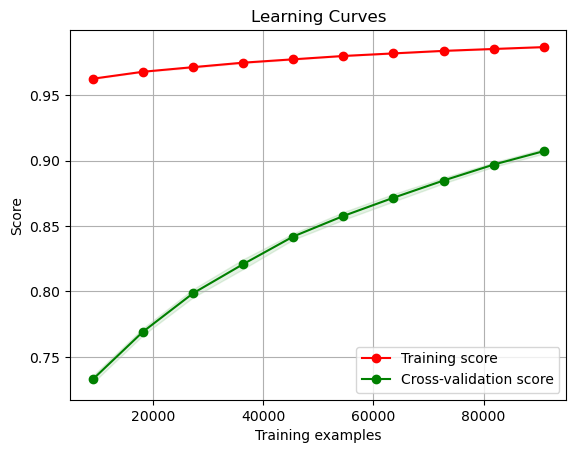

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Function to plot learning curve
def plot_learning_curve(estimator, X_train, y_train, X_test, y_test, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y_train : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    X_test : array-like, shape (n_samples, n_features)
        Test vector, where n_samples is the number of samples and
        n_features is the number of features.

    y_test : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title("Learning Curves")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Load your dataset and split into features (X) and target variable (y)
X = data_copy_clean.drop(["price",'date'], axis=1)
y = data_copy_clean['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Plot the learning curve
plot_learning_curve(rf, X_train, y_train, X_test, y_test, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),n_jobs=1)
plt.show()

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif


# Combine day, month, and year columns into a single datetime column
#data_copy_clean['date'] = pd.to_datetime(data_copy_clean[['year', 'month', 'day']])
data_copy_clean['date'] = pd.to_datetime(data_copy_clean[['year', 'month', 'day']])

# Define the time cutoff date
cutoff_date = pd.to_datetime('2023-06-30')  # Example: YYYY-MM-DD

# Split the dataset based on the time cutoff
train_data = data_copy_clean[data_copy_clean['date'] < cutoff_date]
test_data = data_copy_clean[data_copy_clean['date'] >= cutoff_date]

# Separate features and target variable for training and testing sets
X_train = train_data.drop(["price", "date"], axis=1)  # Exclude the 'date' column from features
y_train = train_data['price']
X_test = test_data.drop(["price", "date"], axis=1)    # Exclude the 'date' column from features
y_test = test_data['price']

# Initialize and train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)

# Evaluate the model on the out-of-time testing data
test_score = model.score(X_test, y_test)
print("Out-of-Time Testing Score:", test_score)

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

C:\Users\anton\AppData\Local\Temp\ipykernel_28076\2381568484.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy_clean['date'] = pd.to_datetime(data_copy_clean[['year', 'month', 'day']])


Out-of-Time Testing Score: 0.8475914198479231
Mean Squared Error (MSE): 2213.6675761834385
R-squared (R2) Value: 0.8475914198479231


In [ ]:
earliest_date = data_copy_clean['date'].min()
latest_date = data_copy_clean['date'].max()

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

In [ ]:
data_copy_clean.info()

In [70]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

X = data_copy_clean.drop(["price",'date'], axis=1)
y = data_copy_clean['price']

original_features = data_copy_clean.drop(["price",'date'], axis=1).columns

# Calculate feature importances
importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, X.columns)

# Set a threshold for feature importance (this is arbitrary and can be adjusted)
threshold = 0.01  # Example threshold

# Select features above the importance threshold
selected_features = feat_importances[feat_importances > threshold].index

# Rebuild the feature set with only selected features
X_selected = X[selected_features]

# Number of features dropped
features_dropped = set(original_features) - set(selected_features)
num_features_dropped = len(features_dropped)

# Number of features remaining
num_features_remaining = len(selected_features)

# Print information about dropped and remaining features
print("Features Dropped:", features_dropped)
print("Number of Features Dropped:", num_features_dropped)
print("Number of Features Remaining:", num_features_remaining)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)

#looking at MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictor variables
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R-squared:", adjusted_r2)

Features Dropped: {'Host greets you', 'Board games', 'neighbourhood_Popincourt', 'season_Autumn', 'has_availability', 'weekday', 'neighbourhood_Entrepôt', 'Cleaning available during stay', 'Piano', 'property_type_Other', 'season_Winter', 'Rice maker', 'backyard', 'neighbourhood_Batignolles-Monceau', 'hot tub', 'calculated_host_listings_count_shared_rooms', 'Single level home', 'property_type_House', 'room_type_Shared room', 'Bread maker', 'Pets allowed', 'season_Summer', 'neighbourhood_Observatoire', 'Breakfast', 'season_Spring', 'neighbourhood_Luxembourg', 'bbq', 'Mini fridge', 'neighbourhood_Reuilly', 'pool', 'Central heating', 'is_holiday', 'exercise equipment', 'neighbourhood_Bourse', 'neighbourhood_Temple', 'game console', 'neighbourhood_Opéra', 'Portable heater', 'Patio or balcony', 'Radiant heating', 'year', 'Elevator', 'is_school_holiday', 'neighbourhood_Hôtel-de-Ville', 'Essentials', 'neighbourhood_Panthéon', 'Sound system', 'day', 'neighbourhood_Palais-Bourbon', 'Heating', 'n

In [64]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

X = data_copy_clean.drop(["price"], axis=1)
y = data_copy_clean['price']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)

#looking at MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error:, {mse:.4f}")

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictor variables
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2:.4f}")

Mean Squared Error:, 1027.7114
R-squared: 0.9289
Adjusted R-squared: 0.9286


In [37]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming data_copy_clean is your DataFrame
# Ensure that only numeric data is used for VIF calculation
numeric_data = data_copy_clean.select_dtypes(include=[np.number])

# Adding a constant column for intercept
numeric_data_with_constant = add_constant(numeric_data)

# Sampling 40% of the data for performance reasons
sampled_data = numeric_data_with_constant.sample(frac=0.4, random_state=42)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = sampled_data.columns
vif_data["VIF"] = [variance_inflation_factor(sampled_data.values, i) for i in range(sampled_data.shape[1])]

print(vif_data)

                                         Feature           VIF
0                                          const  3.140280e+08
1                             host_response_time  4.518600e+00
2                             host_response_rate  4.286211e+00
3                            host_listings_count  4.498862e+01
4                      host_total_listings_count  2.392641e+01
5                                       latitude  1.785569e+01
6                                      longitude  2.259037e+01
7                                   accommodates  3.632031e+00
8                                      bathrooms  1.517244e+00
9                                       bedrooms  2.404065e+00
10                                          beds  3.306371e+00
11                                minimum_nights  2.180863e+00
12                                maximum_nights  1.320657e+00
13                               availability_30  1.541782e+01
14                               availability_60  6.674

In [38]:
# Filter and display features with VIF greater than 5
high_vif_features = vif_data[vif_data["VIF"] > 5]
print("Features with VIF greater than 5:\n", high_vif_features)

Features with VIF greater than 5:
                                         Feature           VIF
0                                         const  3.140280e+08
3                           host_listings_count  4.498862e+01
4                     host_total_listings_count  2.392641e+01
5                                      latitude  1.785569e+01
6                                     longitude  2.259037e+01
13                              availability_30  1.541782e+01
14                              availability_60  6.674492e+01
15                              availability_90  4.250896e+01
18                        number_of_reviews_ltm  5.681773e+00
20                         review_scores_rating  8.229012e+01
21                       review_scores_accuracy  8.549996e+01
22                    review_scores_cleanliness  4.042129e+01
23                        review_scores_checkin  8.113626e+01
24                  review_scores_communication  8.688418e+01
25                       review_sco

In [39]:
columns_to_remove = ['host_listings_count', 'availability_30', 'availability_60', 'review_scores_accuracy', 
                     'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                     'review_scores_location', 'review_scores_value', 'calculated_host_listings_count_entire_homes']

# Dropping the specified columns from the dataset
data = data_copy_clean.drop(columns=columns_to_remove)

# Your dataset now has reduced multicollinearity

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162345 entries, 0 to 162344
Columns: 167 entries, host_response_time to day_of_year
dtypes: bool(133), float64(14), int32(7), int64(13)
memory usage: 58.4 MB


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'target' is your target variable and it's in the original 'data' DataFrame
X = data.drop(['price'],axis=1)
y = data['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_train.shape[1] - 1)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"R-squared adjusted: {adjusted_r2:.4f}")

Mean Squared Error: 1021.5895
R-squared: 0.9293
R-squared adjusted: 0.9291


In [45]:
import pandas as pd

# Load your data
data = data_copy_clean.copy()

# Calculate the correlation matrix
corr_matrix = data.corr()

# Set a threshold for high correlation (for example, 0.8)
high_corr_threshold = 0.8

# Identify features highly correlated with the target variable
target_variable = 'price'  # Replace with your actual target variable name
high_corr_with_target = corr_matrix[target_variable].abs().sort_values(ascending=False)

# Selecting features with high correlation to the target
selected_features = high_corr_with_target[high_corr_with_target > high_corr_threshold].index.tolist()
selected_features.remove(target_variable)  # Remove the target variable itself from the list

# Identify and remove redundant features
redundant_features = set()
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        if abs(corr_matrix.loc[selected_features[i], selected_features[j]]) > high_corr_threshold:
            # Add one of the highly correlated features to the redundant set
            redundant_features.add(selected_features[j])

# Remove redundant features from selected features
final_features = [feature for feature in selected_features if feature not in redundant_features]

# Now, final_features contains the features you want to keep
print("Selected features:", final_features)

Selected features: []


In [48]:
# Set a threshold for identifying high correlations (e.g., 0.8 or 0.9)
high_corr_threshold = 0.8


# Calculate the correlation matrix
corr_matrix = data.corr()

# Find pairs of highly correlated features
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Print out the highly correlated pairs
for pair in high_corr_pairs:
    print(f"Feature pair: {pair[0]}, {pair[1]} - Correlation: {pair[2]:.2f}")

Feature pair: host_response_time, host_response_rate - Correlation: -0.85
Feature pair: latitude, Sacré-Cœur Basilica Distance - Correlation: -0.88
Feature pair: longitude, Eiffel Tower Distance - Correlation: 0.93
Feature pair: longitude, Arc de Triomphe Distance - Correlation: 0.85
Feature pair: accommodates, beds - Correlation: 0.81
Feature pair: number_of_reviews, reviews_per_month - Correlation: 0.81
Feature pair: review_scores_rating, zero_reviews - Correlation: -0.94
Feature pair: calculated_host_listings_count_private_rooms, room_type_Private room - Correlation: 0.82
Feature pair: Dishes and silverware, refrigerator - Correlation: 0.82
Feature pair: Eiffel Tower Distance, Arc de Triomphe Distance - Correlation: 0.88
Feature pair: Louvre Museum Distance, Notre-Dame Cathedral Distance - Correlation: 0.81
Feature pair: room_type_Entire home/apt, room_type_Private room - Correlation: -0.90
Feature pair: month, day_of_year - Correlation: 1.00


In [51]:
columns_to_remove = ['host_listings_count', 'availability_30', 'availability_60', 'review_scores_accuracy', 
                    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                     'review_scores_location', 'review_scores_value', 'calculated_host_listings_count_entire_homes'
                   ,'number_of_reviews_ltm','calculated_host_listings_count','Cooking basics']
# Dropping the specified columns from the dataset
data = data.drop(columns=columns_to_remove)

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a new DataFrame with only the selected features
X = data.drop('price',axis=1)
y = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_train.shape[1] - 1)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"R-squared adjusted: {adjusted_r2:.4f}")

Mean Squared Error: 1022.8098
R-squared: 0.9292
R-squared adjusted: 0.9290


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162345 entries, 0 to 162344
Columns: 164 entries, host_response_time to day_of_year
dtypes: bool(132), float64(14), int32(7), int64(11)
memory usage: 55.7 MB


## 2. XGB k-fold cross validation and out-of-time validation

In [53]:
!pip install pandas scikit-learn xgboost matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Split the data into features (X) and target variable (y)
X = data_copy_clean.drop(['price'], axis=1)
y = data_copy_clean['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate XGBoost Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

Mean Squared Error (MSE): 2269.4637230722014
R-squared (R2) Value: 0.8429361708789973


In [ ]:
#!pip install pandas scikit-learn xgboost matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Split the data into features (X) and target variable (y)
X = data_copy_clean.drop(['price','date'], axis=1)
y = data_copy_clean['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the number of folds for cross-validation
k = 10

# Initialize the k-fold cross-validation method
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Instantiate XGBoost Regressor
model = xgb.XGBRegressor()

# Perform k-fold cross-validation
cv_results = cross_val_score(model, X, y, cv=kf, n_jobs=4)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_results)

# Calculate the mean and standard deviation of cross-validation scores
print("Mean CV Score:", cv_results.mean())
print("Standard Deviation of CV Scores:", cv_results.std())

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

In [ ]:
#!pip install pandas scikit-learn xgboost matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Define the time cutoff date
cutoff_date = pd.to_datetime('2023-06-30')  # Example: YYYY-MM-DD

# Split the dataset based on the time cutoff
train_data = data_copy_clean[data_copy_clean['date'] < cutoff_date]
test_data = data_copy_clean[data_copy_clean['date'] >= cutoff_date]

# Separate features and target variable for training and testing sets
X_train = train_data.drop(["price", "date"], axis=1)  # Exclude the 'date' column from features
y_train = train_data['price']
X_test = test_data.drop(["price", "date"], axis=1)    # Exclude the 'date' column from features
y_test = test_data['price']

# Instantiate XGBoost Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the out-of-time testing data
test_score = model.score(X_test, y_test)
print("Out-of-Time Testing Score:", test_score)

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

In [54]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

X = data_copy_clean.drop(["price"], axis=1)
y = data_copy_clean['price']

original_features = data_copy_clean.drop(["price"], axis=1).columns

# Calculate feature importances
importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, X.columns)

# Set a threshold for feature importance (this is arbitrary and can be adjusted)
threshold = 0.01  # Example threshold

# Select features above the importance threshold
selected_features = feat_importances[feat_importances > threshold].index

# Rebuild the feature set with only selected features
X_selected = X[selected_features]

# Number of features dropped
features_dropped = set(original_features) - set(selected_features)
num_features_dropped = len(features_dropped)

# Number of features remaining
num_features_remaining = len(selected_features)

# Print information about dropped and remaining features
print("Features Dropped:", features_dropped)
print("Number of Features Dropped:", num_features_dropped)
print("Number of Features Remaining:", num_features_remaining)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf = xgb.XGBRegressor()
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)

#looking at MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictor variables
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R-squared:", adjusted_r2)

C:\Users\anton\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\anton\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Features Dropped: {'Private entrance', 'Host greets you', 'Board games', 'neighbourhood_Popincourt', 'month', 'season_Autumn', 'has_availability', 'neighbourhood_Élysée', 'weekday', 'neighbourhood_Louvre', 'neighbourhood_Entrepôt', 'Cleaning available during stay', 'Piano', 'property_type_Other', 'gym', 'season_Winter', 'Rice maker', 'backyard', 'neighbourhood_Batignolles-Monceau', 'hot tub', 'calculated_host_listings_count_shared_rooms', 'Single level home', 'property_type_House', 'room_type_Shared room', 'Bread maker', 'Pets allowed', 'season_Summer', 'neighbourhood_Observatoire', 'zero_reviews', 'Breakfast', 'season_Spring', 'neighbourhood_Luxembourg', 'bbq', 'Mini fridge', 'neighbourhood_Reuilly', 'pool', 'Central heating', 'is_holiday', 'exercise equipment', 'sound system', 'Blender', 'game console', 'neighbourhood_Opéra', 'Outdoor dining area', 'Portable heater', 'Patio or balcony', 'Radiant heating', 'year', 'is_school_holiday', 'neighbourhood_Hôtel-de-Ville', 'Essentials', 'nei

In [55]:
columns_to_remove = ['host_listings_count', 'availability_30', 'availability_60', 'review_scores_accuracy', 
                     'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                     'review_scores_location', 'review_scores_value', 'calculated_host_listings_count_entire_homes']

# Dropping the specified columns from the dataset
data = data_copy_clean.drop(columns=columns_to_remove)

# Your dataset now has reduced multicollinearity

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162345 entries, 0 to 162344
Columns: 167 entries, host_response_time to day_of_year
dtypes: bool(133), float64(14), int32(7), int64(13)
memory usage: 58.4 MB


In [56]:
#!pip install pandas scikit-learn xgboost matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Split the data into features (X) and target variable (y)
X = data.drop(['price'], axis=1)
y = data['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate XGBoost Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

Mean Squared Error (MSE): 2291.5349860978804
R-squared (R2) Value: 0.8414086747356982


In [59]:
columns_to_remove = ['host_listings_count', 'availability_30', 'availability_60', 'review_scores_accuracy', 
                    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                     'review_scores_location', 'review_scores_value', 'calculated_host_listings_count_entire_homes'
                   ,'number_of_reviews_ltm','calculated_host_listings_count','Cooking basics']
# Dropping the specified columns from the dataset
data = data_copy_clean.drop(columns=columns_to_remove)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162345 entries, 0 to 162344
Columns: 164 entries, host_response_time to day_of_year
dtypes: bool(132), float64(14), int32(7), int64(11)
memory usage: 55.7 MB


In [60]:
#!pip install pandas scikit-learn xgboost matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Split the data into features (X) and target variable (y)
X = data.drop(['price'], axis=1)
y = data['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate XGBoost Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

Mean Squared Error (MSE): 2338.6906705598885
R-squared (R2) Value: 0.8381451493965937


## 3. Linear model with k fold cross-validation and out-of-time

In [ ]:
#!pip install pandas scikit-learn xgboost matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression

# Split the data into features (X) and target variable (y)
X = data_copy_clean.drop(['price'], axis=1)
y = data_copy_clean['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the number of folds for cross-validation
k = 5

# Initialize the k-fold cross-validation method
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Instantiate XGBoost Regressor
model = LinearRegression()

# Perform k-fold cross-validation
cv_results = cross_val_score(model, X, y, cv=kf, n_jobs=4)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_results)

# Calculate the mean and standard deviation of cross-validation scores
print("Mean CV Score:", cv_results.mean())
print("Standard Deviation of CV Scores:", cv_results.std())

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

In [ ]:
#!pip install pandas scikit-learn xgboost matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression


# Define the time cutoff date
cutoff_date = pd.to_datetime('2023-06-30')  # Example: YYYY-MM-DD

# Split the dataset based on the time cutoff
train_data = data_copy_clean[data_copy_clean['date'] < cutoff_date]
test_data = data_copy_clean[data_copy_clean['date'] >= cutoff_date]

# Separate features and target variable for training and testing sets
X_train = train_data.drop(["price", "date"], axis=1)  # Exclude the 'date' column from features
y_train = train_data['price']
X_test = test_data.drop(["price", "date"], axis=1)    # Exclude the 'date' column from features
y_test = test_data['price']

# Instantiate XGBoost Regressor
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the out-of-time testing data
test_score = model.score(X_test, y_test)
print("Out-of-Time Testing Score:", test_score)

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

In [76]:
data_copy_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162345 entries, 0 to 162344
Columns: 178 entries, host_response_time to date
dtypes: bool(133), datetime64[ns](1), float64(21), int32(7), int64(16)
memory usage: 72.0 MB


In [75]:
#!pip install pandas scikit-learn xgboost matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression

# Split the data into features (X) and target variable (y)
X = data_copy_clean.drop(['price','date'], axis=1)
y = data_copy_clean['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate XGBoost Regressor
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

Mean Squared Error (MSE): 4874.400019002655
R-squared (R2) Value: 0.6626551357182948


In [77]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

X = data_copy_clean.drop(["price","date"], axis=1)
y = data_copy_clean['price']

original_features = data_copy_clean.drop(["price","date"], axis=1).columns

# Calculate feature importances
importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, X.columns)

# Set a threshold for feature importance (this is arbitrary and can be adjusted)
threshold = 0.01  # Example threshold

# Select features above the importance threshold
selected_features = feat_importances[feat_importances > threshold].index

# Rebuild the feature set with only selected features
X_selected = X[selected_features]

# Number of features dropped
features_dropped = set(original_features) - set(selected_features)
num_features_dropped = len(features_dropped)

# Number of features remaining
num_features_remaining = len(selected_features)

# Print information about dropped and remaining features
print("Features Dropped:", features_dropped)
print("Number of Features Dropped:", num_features_dropped)
print("Number of Features Remaining:", num_features_remaining)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf = LinearRegression()
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)

#looking at MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictor variables
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R-squared:", adjusted_r2)

Features Dropped: {'Private entrance', 'Host greets you', 'Board games', 'neighbourhood_Popincourt', 'month', 'season_Autumn', 'has_availability', 'weekday', 'neighbourhood_Louvre', 'neighbourhood_Entrepôt', 'Cleaning available during stay', 'Piano', 'property_type_Other', 'gym', 'season_Winter', 'Rice maker', 'backyard', 'neighbourhood_Batignolles-Monceau', 'hot tub', 'calculated_host_listings_count_shared_rooms', 'Single level home', 'property_type_House', 'room_type_Shared room', 'Bread maker', 'Pets allowed', 'season_Summer', 'neighbourhood_Observatoire', 'zero_reviews', 'Breakfast', 'season_Spring', 'neighbourhood_Luxembourg', 'bbq', 'Mini fridge', 'neighbourhood_Reuilly', 'pool', 'Central heating', 'is_holiday', 'neighbourhood_Buttes-Chaumont', 'exercise equipment', 'neighbourhood_Bourse', 'neighbourhood_Temple', 'Blender', 'game console', 'neighbourhood_Opéra', 'Outdoor dining area', 'Portable heater', 'Patio or balcony', 'Radiant heating', 'year', 'Elevator', 'is_school_holiday

In [78]:
columns_to_remove = ['host_listings_count', 'availability_30', 'availability_60', 'review_scores_accuracy', 
                     'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                     'review_scores_location', 'review_scores_value', 'calculated_host_listings_count_entire_homes']

# Dropping the specified columns from the dataset
data = data_copy_clean.drop(columns=columns_to_remove)

# Your dataset now has reduced multicollinearity

In [81]:
#!pip install pandas scikit-learn xgboost matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression

# Split the data into features (X) and target variable (y)
X = data.drop(['price','date'], axis=1)
y = data['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate XGBoost Regressor
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

#MSE value calculated 
mse_score = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_score)

#r2_score calculated
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Value:", r2)

Mean Squared Error (MSE): 4949.272747017018
R-squared (R2) Value: 0.6574733840828239


In [80]:
columns_to_remove = ['host_listings_count', 'availability_30', 'availability_60', 'review_scores_accuracy', 
                    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                     'review_scores_location', 'review_scores_value', 'calculated_host_listings_count_entire_homes'
                   ,'number_of_reviews_ltm','calculated_host_listings_count','Cooking basics']
# Dropping the specified columns from the dataset
data = data_copy_clean.drop(columns=columns_to_remove)

# Adding new spatial features

In [ ]:
import pandas as pd
from geopy.distance import great_circle

# Define the monuments and their coordinates
monuments = {
    "Eiffel Tower": (48.8584, 2.2945),
    "Louvre Museum": (48.8606, 2.3376),
    "Notre-Dame Cathedral": (48.8529, 2.3500),
    "Sacré-Cœur Basilica": (48.8867, 2.3431),
    "Arc de Triomphe": (48.8738, 2.2950)
}

# Calculate distances and add as new columns
for monument, coords in monuments.items():
    data_copy_clean[monument + ' Distance'] = data_copy_clean.apply(lambda row: great_circle((row['latitude'], row['longitude']), coords).kilometers,axis=1)

# Now data_copy_clean has new columns with distances to each monument

In [ ]:
data_copy_clean.iloc[:, -1].head()

In [ ]:
data_copy_clean1.info()

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

X = data.drop("price", axis=1)
y = data['price']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)

#looking at MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error:, {mse:.4f}")

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictor variables
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2:.4f}")

In [ ]:
import pandas as pd
import geopy.distance

# Define coordinates for some major hospitals in Paris
hospitals = {
    "Hopital Europeen Georges-Pompidou": (48.8397, 2.2727),
    "Hopital Pitie-Salpetriere": (48.8373, 2.3610),
    "Hopital Saint-Louis": (48.8753, 2.3707),
    "Hopital Cochin": (48.8375, 2.3365),
    "Hopital Lariboisiere": (48.8798, 2.3532)
}

# Function to calculate the distance to a hospital
def calculate_distance(lat, lon, hospital_coord):
    return geopy.distance.distance((lat, lon), hospital_coord).km

# Calculate distances from each listing to each hospital and create new columns
for hospital_name, hospital_coord in hospitals.items():
    column_name = f'distance_to_{hospital_name}'
    data[column_name] = data.apply(lambda x: calculate_distance(x['latitude'], x['longitude'], hospital_coord), axis=1)

data.iloc[:, -1].head()

In [ ]:
import pandas as pd
import geopy.distance

# Define coordinates for major stations in Paris
stations = {
    "Gare du Nord": (48.8809, 2.3553),
    "Gare de l'Est": (48.8763, 2.3592),
    "Gare Saint-Lazare": (48.8768, 2.3254),
    "Gare de Lyon": (48.8443, 2.3740),
    "Gare Montparnasse": (48.8406, 2.3195),
    "Gare d'Austerlitz": (48.8421, 2.3664)
}

# Function to calculate the distance to a station
def calculate_distance(lat, lon, station_coord):
    return geopy.distance.distance((lat, lon), station_coord).km

# Calculate distances from each listing to each station and create new columns
for station_name, station_coord in stations.items():
    column_name = f'distance_to_{station_name}'
    data_copy_clean1[column_name] = data_copy_clean1.apply(lambda x: calculate_distance(x['latitude'], x['longitude'], station_coord), axis=1)

data_copy_clean1.iloc[:, -1].head()

In [ ]:
import pandas as pd
from geopy.distance import geodesic

data_copy_clean2 = data_copy_clean.copy()
# Define the coordinates for districts in Paris
district_coordinates = {
    'Marais': (48.8592, 2.3583),
    'Montmartre': (48.8867, 2.3431),
    'Saint-Germain-des-Prés': (48.8530, 2.3333),
    # Add more districts as needed
}

# Function to calculate distance between two coordinates
def calculate_distance(listing_lat, listing_lon, district_coord):
    listing_coord = (listing_lat, listing_lon)
    return geodesic(listing_coord, district_coord).kilometers

# Add columns for distance to each district
for district, coord in district_coordinates.items():
    data_copy_clean2[f'Distance_to_{district}'] = data_copy_clean2.apply(
        lambda row: calculate_distance(row['latitude'], row['longitude'], coord),
        axis=1
    )

data_copy_clean2.iloc[:, -1].head()

In [ ]:
import pandas as pd
from geopy.distance import geodesic

data_copy_clean3 = data_copy_clean.copy()

# Define the coordinates for shopping centers, markets, and retail districts
shopping_coordinates = {
    'Galeries Lafayette': (48.8738, 2.3325),  # Example coordinates, replace with actual values
    'Le Bon Marché': (48.8505, 2.3289),        # Example coordinates, replace with actual values
    'Marché aux Puces de Saint-Ouen': (48.9055, 2.3400),  # Example coordinates, replace with actual values
    # Add more shopping destinations as needed
}

# Function to calculate distance between two coordinates
def calculate_distance(listing_lat, listing_lon, shopping_coord):
    listing_coord = (listing_lat, listing_lon)
    return geodesic(listing_coord, shopping_coord).kilometers

# Add columns for distance to each shopping destination
for shopping_location, coord in shopping_coordinates.items():
    data_copy_clean3[f'Distance_to_{shopping_location}'] = data_copy_clean3.apply(
        lambda row: calculate_distance(row['latitude'], row['longitude'], coord),
        axis=1
    )

data_copy_clean3.iloc[:, -1].head()